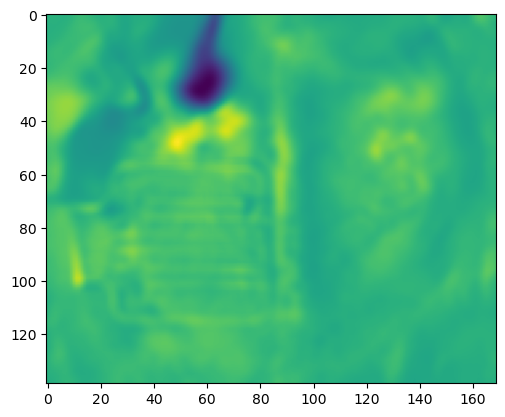

In [5]:
#python -m tensorboard.main --logdir VPTR_ckpts/MNIST_ResNetAE_MSEGDLgan_tensorboard
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt


import tifffile

from pathlib import Path
import random
from datetime import datetime
from time import sleep
from tqdm import tqdm

from customdatasets import SegmentationData
from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import get_dataloader
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, update_summary, write_summary, resume_training
from utils import set_seed

set_seed(2021)

def cal_lossD(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.detach().flatten(0, 1))
    loss_D_fake = gan_loss(pred_fake, False)
    # Real
    pred_real = VPTR_Disc(real_imgs.flatten(0,1))
    loss_D_real = gan_loss(pred_real, True)
    # combine loss and calculate gradients
    loss_D = (loss_D_fake + loss_D_real) * 0.5 * lam_gan

    return loss_D, loss_D_fake, loss_D_real
    
def cal_lossG(VPTR_Disc, fake_imgs, real_imgs, lam_gan):
    pred_fake = VPTR_Disc(fake_imgs.flatten(0, 1))
    loss_G_gan = gan_loss(pred_fake, True)
    
    AE_MSE_loss = mse_loss(fake_imgs, real_imgs)
    AE_GDL_loss = gdl_loss(real_imgs, fake_imgs)
    #AE_L1_loss = l1_loss(fake_imgs, real_imgs)

    loss_G = lam_gan * loss_G_gan + AE_MSE_loss + AE_GDL_loss

    return loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss

def single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, optimizer_D, sample, device, train_flag = True):
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    x = torch.cat([past_frames, future_frames], dim = 1)
    
    if train_flag:
        VPTR_Enc = VPTR_Enc.train()
        VPTR_Enc.zero_grad()
        VPTR_Dec = VPTR_Dec.train()
        VPTR_Dec.zero_grad()

        
        rec_frames = VPTR_Dec(VPTR_Enc(x))

        #update discriminator
        VPTR_Disc = VPTR_Disc.train()
        for p in VPTR_Disc.parameters():
            p.requires_grad_(True)
        VPTR_Disc.zero_grad(set_to_none=True)

        loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, rec_frames, x, lam_gan)
        loss_D.backward()
        optimizer_D.step()

        #update autoencoder (generator)
        for p in VPTR_Disc.parameters():
            p.requires_grad_(False)
        loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss = cal_lossG(VPTR_Disc, rec_frames, x, lam_gan)
        loss_G.backward()
        optimizer_G.step()
    else:
        VPTR_Enc = VPTR_Enc.eval()
        VPTR_Dec = VPTR_Dec.eval()
        VPTR_Disc = VPTR_Disc.eval()
        with torch.no_grad():
            rec_frames = VPTR_Dec(VPTR_Enc(x))
            loss_D, loss_D_fake, loss_D_real = cal_lossD(VPTR_Disc, rec_frames, x, lam_gan)
            loss_G, loss_G_gan, AE_MSE_loss, AE_GDL_loss = cal_lossG(VPTR_Disc, rec_frames, x, lam_gan)
        
    iter_loss_dict = {'AEgan': loss_G_gan.item(), 'AE_MSE': AE_MSE_loss.item(), 'AE_GDL': AE_GDL_loss.item(), 'AE_total': loss_G.item(), 'Dtotal': loss_D.item(), 'Dfake':loss_D_fake.item(), 'Dreal':loss_D_real.item()}
    
    return iter_loss_dict

def show_samples(VPTR_Enc, VPTR_Dec, sample, save_dir, renorm_transform):
    VPTR_Enc = VPTR_Enc.eval()
    VPTR_Dec = VPTR_Dec.eval()
    with torch.no_grad():
        past_frames, future_frames = sample
        past_frames = past_frames.to(device)
        future_frames = future_frames.to(device)

        past_gt_feats = VPTR_Enc(past_frames)
        future_gt_feats = VPTR_Enc(future_frames)

        rec_past_frames = VPTR_Dec(past_gt_feats)
        rec_future_frames = VPTR_Dec(future_gt_feats)

        N = future_frames.shape[0]
        idx = min(N, 4)
        visualize_batch_clips(past_frames[0:idx, :, ...], rec_future_frames[0:idx, :, ...], rec_past_frames[0:idx, :, ...], save_dir, renorm_transform, desc = 'ae')

if __name__ == '__main__':
    run = "1"

    ckpt_save_dir = Path('./VPTR_chkpts/MNIST_ResNetAE_MSEGDLgan_ckpt/')
    tensorboard_save_dir = Path('./VPTR_chkpts/MNIST_ResNetAE_MSEGDLgan_tensorboard/'+run)
    
    resume_ckpt = ckpt_save_dir.joinpath('epoch_2.tar')
    #resume_ckpt = None
    start_epoch = 2

    summary_writer = SummaryWriter(tensorboard_save_dir.absolute().as_posix())
    num_past_frames = 10
    num_future_frames = 10
    encH, encW, encC = 8, 8, 528
    img_channels = 1 #3 channels for BAIR datset
    epochs = 50
    N = 1
    AE_lr = 2e-4
    lam_gan = 0.01
    device = torch.device('cuda:0')

    #####################Init Dataset ###########################
    data_set_name = 'MNIST' #see utils.dataset
    dataset_dir = './MovingMNIST/'
    train_loader, val_loader, test_loader, renorm_transform = get_dataloader(data_set_name, N, dataset_dir, num_past_frames, num_future_frames)
    
    sample_np = tifffile.memmap("../dataset-1/210202/normalized/07_baseline_norm.tif", mode='r')
    data_train = SegmentationData(
        inputs=sample_np[0:10], augment=None
    )
    training_dataloader = DataLoader(dataset=data_train, batch_size=1, shuffle=True)
    import time
    
    for sample in iter(training_dataloader):
 
        plt.imshow(sample[0])
        time.sleep(1)



    
    # #####################Init Models and Optimizer ###########################
    # VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3).to(device)
    # VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh').to(device) #Sigmoid for MNIST, Tanh for KTH and BAIR
    # VPTR_Disc = VPTRDisc(img_channels, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d).to(device)
    # init_weights(VPTR_Disc)
    # init_weights(VPTR_Enc)
    # init_weights(VPTR_Dec)

    # optimizer_G = torch.optim.Adam(params = list(VPTR_Enc.parameters()) + list(VPTR_Dec.parameters()), lr=AE_lr, betas = (0.5, 0.999))
    # optimizer_D = torch.optim.Adam(params = VPTR_Disc.parameters(), lr=AE_lr, betas = (0.5, 0.999))

    # Enc_parameters = sum(p.numel() for p in VPTR_Enc.parameters() if p.requires_grad)
    # Dec_parameters = sum(p.numel() for p in VPTR_Dec.parameters() if p.requires_grad)
    # Disc_parameters = sum(p.numel() for p in VPTR_Disc.parameters() if p.requires_grad)
    # print(f"Encoder num_parameters: {Enc_parameters}")
    # print(f"Decoder num_parameters: {Dec_parameters}")
    # print(f"Discriminator num_parameters: {Disc_parameters}")

    # #####################Init Criterion ###########################
    # loss_name_list = ['AE_MSE', 'AE_GDL', 'AE_total', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']
    # gan_loss = GANLoss('vanilla', target_real_label=1.0, target_fake_label=0.0).to(device)
    # loss_dict = init_loss_dict(loss_name_list)
    # mse_loss = MSELoss()
    # gdl_loss = GDL(alpha = 1)

    # if resume_ckpt is not None:
    #     loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec, 'VPTR_Disc': VPTR_Disc}, 
    #                                             {'optimizer_G': optimizer_G, 'optimizer_D': optimizer_D}, resume_ckpt,
    #                                             loss_name_list)

    # #####################Training loop ###########################                                            
    # for epoch in range(start_epoch+1, start_epoch + epochs+1):
    #     epoch_st = datetime.now()
    #     #Train
    #     EpochAveMeter = AverageMeters(loss_name_list)
    #     with tqdm(enumerate(train_loader, 0), unit=" batch", total=len(train_loader)) as tepoch:
    #         for idx, sample in tepoch:
    #             tepoch.set_description(f"Epoch {epoch}")
    #             iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, optimizer_D, sample, device, train_flag = True)
    #             EpochAveMeter.iter_update(iter_loss_dict)
    #             update_summary(summary_writer, iter_loss_dict, idx, train_flag = True)
    #             tepoch.set_postfix(loss=iter_loss_dict["AE_total"])
    #             sleep(0.1)
    #         write_summary(summary_writer, loss_dict, train_flag = True)

    #         loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = True)
            
    #         show_samples(VPTR_Enc, VPTR_Dec, sample, ckpt_save_dir.joinpath(f'train_gifs_epoch{epoch}'), renorm_transform)
            
    #         #validation
    #         EpochAveMeter = AverageMeters(loss_name_list)
    #         for idx, sample in enumerate(val_loader, 0):
    #             iter_loss_dict = single_iter(VPTR_Enc, VPTR_Dec, VPTR_Disc, optimizer_G, optimizer_D, sample, device, train_flag = False)
    #             EpochAveMeter.iter_update(iter_loss_dict)
    #         loss_dict = EpochAveMeter.epoch_update(loss_dict, epoch, train_flag = False)
    #         write_summary(summary_writer, loss_dict, train_flag = False)
            
    #         save_ckpt({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec, 'VPTR_Disc': VPTR_Disc}, 
    #                 {'optimizer_G': optimizer_G, 'optimizer_D': optimizer_D}, 
    #                 epoch, loss_dict, ckpt_save_dir)
    #         for idx, sample in enumerate(test_loader, random.randint(0, len(test_loader) - 1)):
    #             show_samples(VPTR_Enc, VPTR_Dec, sample, ckpt_save_dir.joinpath(f'test_gifs_epoch{epoch}'), renorm_transform)
    #             break
                
    #         epoch_time = datetime.now() - epoch_st
    #         print(f'epoch {epoch}', EpochAveMeter.meters['AE_total'])
    #         print(f"Estimated remaining training time: {epoch_time.total_seconds()/3600. * (start_epoch + epochs - epoch)} Hours")
            